In [1]:
from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.core.sampling import Sampling

import multiprocessing
from pymoo.core.problem import StarmapParallelization


import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import plotly.express as px

from sklearn import svm
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('../Liver_GSE14520_U133A.csv')

### Normalização

In [3]:
colunas = list(data.columns)
colunas.remove('samples')
colunas.remove('type')

for i in (range(len(colunas))):
    coluna = colunas[i]
    data[coluna] = (data[coluna] - data[coluna].mean())/np.std(data[coluna])

In [4]:
X = data[colunas]
y = data['type']

### Definindo função de avaliação do problema

In [5]:
class GeneSelection(ElementwiseProblem):
    def __init__(self, X, y, runner):
        self.X = X
        self.y = y
        self.n_features = X.shape[1]
        self.eval_dict = {'n_features':[], 'f1_score':[]}
        super().__init__(n_var=self.n_features,
    						n_obj=2,
    						n_constr=0,
    						xl=np.zeros(self.n_features),
    						xu=np.ones(self.n_features),
    						elementwise_evaluation=True,
                            type_var=bool,
                            save_history=True,
                            elementwise_runner=runner)

    def _evaluate(self, x, out, *args, **kwargs):
    	# seleciona as features de acordo com o vetor binário
        selected_features = np.where(x == 1)[-1]
        X_selected = self.X.iloc[:,selected_features]
    	
        # Kfolding usado para separar em treino e teste
        skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
        #X_train, X_valid, y_train, y_valid = train_test_split(X_selected, self.y, test_size=0.1, random_state=100)
    	
    	# treino usando modelo SVM
        clf = svm.SVC(kernel='linear')

        # compute f_1 and AUC on validation set
        f_1 = np.mean(cross_val_score(clf, X_selected, self.y, cv=skf, scoring='f1_macro'))
        n_features = len(selected_features)
        # salvar os resultados
        self.eval_dict['n_features'].append(n_features)
        self.eval_dict['f1_score'].append(f_1)
    	
    	# define os objetivos a serem minimizados
        out["F"] = [n_features, -f_1]

### Definindo funções customizadas

In [34]:
class BinaryDistributedRandomSampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        val = np.random.random((n_samples, problem.n_var))
        div = 1/n_samples
        final = []
        for i in val:
            final.append((i < div).astype(bool))
            div += 1/n_samples
        return np.array(final)

### Rodando o modelo de otimização

In [37]:
# initialize the thread pool and create the runner
n_proccess = 96
pool = multiprocessing.Pool(n_proccess)
runner = StarmapParallelization(pool.starmap)

In [38]:
X_ = X.iloc[:,:1000].copy()
problem = GeneSelection(X_,y.copy().values, runner)
algorithm = NSGA2(pop_size=96,
				  sampling=BinaryDistributedRandomSampling(),
				  crossover=TwoPointCrossover(),
				  mutation=BitflipMutation(),
                 save_history = True)

In [46]:
res = minimize(problem,  # problem class
			    algorithm,  # NSGA2 algorithm
                ("n_gen", 500), # number of iteration for eval problem class
			    verbose=True)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       96 |      6 |             - |             -
     2 |      192 |      7 |  0.5272727273 |         nadir
     3 |      288 |     12 |  0.0436264795 |         ideal
     4 |      384 |     12 |  0.0307058770 |             f
     5 |      480 |     12 |  0.6766666667 |         nadir
     6 |      576 |     13 |  0.0138462342 |             f
     7 |      672 |     14 |  0.0178349231 |             f
     8 |      768 |     16 |  0.0412681153 |         ideal
     9 |      864 |     15 |  0.0401615558 |         ideal
    10 |      960 |     18 |  0.0450038035 |         ideal
    11 |     1056 |     20 |  0.0177948858 |             f
    12 |     1152 |     18 |  0.0097451247 |             f
    13 |     1248 |      7 |  0.0083333333 |         ideal
    14 |     1344 |      7 |  0.000000E+00 |             f
    15 |     1440 |     10 |  0.1650485437 |         nadir
    16 |     1536 |     10 |  0.0208887523 |            

500


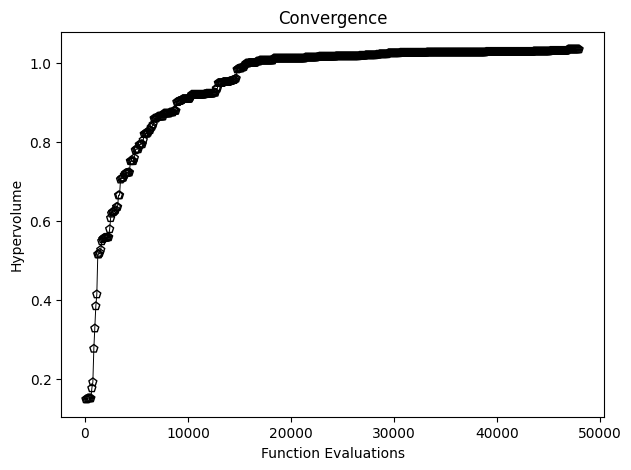

In [55]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

X_res, F_res = res.opt.get("X", "F")

hist = res.history
print(len(hist))
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])
approx_ideal = F_res.min(axis=0)
approx_nadir = F_res.max(axis=0)
from pymoo.indicators.hv import Hypervolume

metric = Hypervolume(ref_point= np.array([1.1, 1.1]),
                     norm_ref_point=False,
                     zero_to_one=True,
                     ideal=approx_ideal,
                     nadir=approx_nadir)

hv = [metric.do(_F) for _F in hist_F]

plt.figure(figsize=(7, 5))
plt.plot(n_evals, hv,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, hv,  facecolor="none", edgecolor='black', marker="p")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

In [54]:
F_res

array([[ 2.        , -0.96085809],
       [ 1.        , -0.9158063 ],
       [ 4.        , -0.97761905],
       [ 3.        , -0.9776169 ],
       [ 4.        , -0.97761905],
       [ 5.        , -0.98317353],
       [10.        , -0.98321002],
       [11.        , -0.9860258 ],
       [13.        , -0.98880733],
       [27.        , -0.99154706],
       [28.        , -0.99718086]])

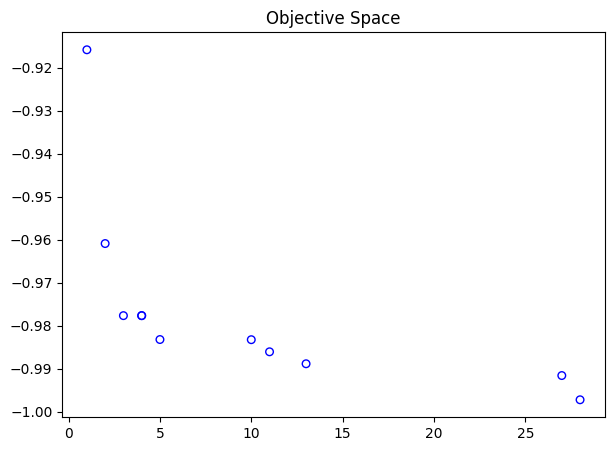

In [53]:
plt.figure(figsize=(7, 5))
plt.scatter(F_res[:, 0], F_res[:, 1], s=30, facecolors='none', edgecolors='blue')
plt.title("Objective Space")
plt.show()

### Testes aleatório aqui em baixo

In [123]:
X_ = X[['1007_s_at','1053_at','117_at','121_at','1255_g_at']]
x = np.array([0,0,1,1,0])
selected_features = np.where(x == 1)[-1]
X_selected = X_.iloc[:,selected_features]
X_selected

,117_at,121_at
0,6.099383,-0.757729
1,-0.512948,1.011581
2,-1.234539,-0.868440
3,-0.531929,-0.095346
4,0.149404,2.064896
...,...,...
352,-0.249716,1.587687
353,0.058384,-0.678534
354,-0.450980,-0.307648
355,-0.196550,0.339411


In [124]:
X.iloc[:,:100].shape[1]

100

In [125]:
X.shape[1]

22277

NameError: name 'callback' is not defined

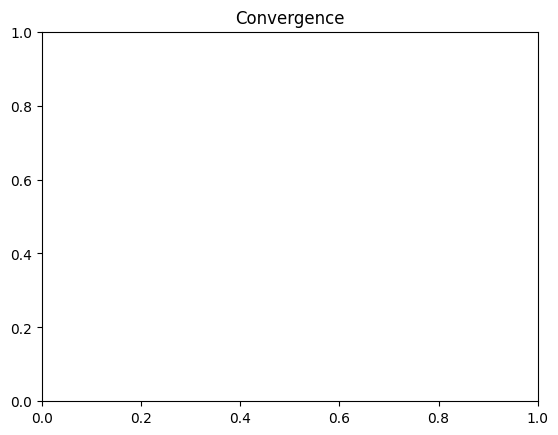

In [145]:
plt.title("Convergence")
plt.plot(callback.n_evals, callback.opt, "--")
plt.yscale("log")
plt.show()

In [162]:
res.exec_time

115.5875256061554

In [216]:
X_res, F_res = res.opt.get("X", "F")


In [28]:
val = np.random.random((10, 20))
div = 1/10
final = []
for i in val:
    print(((i < div).astype(bool)).sum())
    div += 1/10
print(np.array(final).sum())

1
6
7
8
7
10
15
16
17
20
0.0


In [ ]:
class BinaryDistributedRandomSampling(Sampling):

    def _do(self, problem, n_samples, **kwargs):
        val = np.random.random((n_samples, problem.n_var))
        div = 1/n_samples
        final = []
        for i in val:
            final.append((i < div).astype(bool))
            div += 1/n_samples
        return np.array(final)

In [32]:
sampling = BinaryDistributedRandomSampling()
aff = sampling(problem, 10).get("X")
for a in aff:
    print (a.sum())

108
188
307
388
510
590
682
814
907
1000
